In [49]:
import numpy as np
import math
import scipy as sp
from scipy import optimize
from numpy import genfromtxt
import pandas as pd 
import glob
import pymc as pm
import arviz as az
import statistics as stats
import matplotlib.pyplot as plt
import os,sys

In [50]:
# getting the name of the directory
# where the this file is present.
# current = os.path.dirname(os.path.realpath(__file__))
current = os.path.dirname(os.getcwd())
 
# Getting the parent directory name
# where the current directory is present.
# parent = os.path.dirname(os.path.dirname(current))
parent = current
print(parent)
#/Users/pizarror/IDM

# adding the parent directory to
# the sys.path.
sys.path.append(parent)

from IDM_model.src import model_functions as mf

/Users/pizarror/IDM


In [51]:
def read_load_data(subject='23_IDM_0144',fn='/tmp',alpha0=1.0,cols=[]):
    df = pd.read_csv(fn)
    # remove practice trials
    df = df.loc[df['cdd_trial_type']=='task']
    # insert probability as choice into data
    # cols = ['cdd_trial_resp.corr','cdd_immed_amt','cdd_delay_amt','cdd_immed_wait','cdd_delay_wait','alpha']
    # also returns percent_reward which we do not need here
    data = mf.get_data(df,cols,alpha_hat=alpha0)[0]
    data['subject'] = subject
    # vn = data['cdd_immed_amt'].to_list()
    # vr = data['cdd_delay_amt'].to_list()
    # tn = data['cdd_immed_wait'].to_list()
    # tr = data['cdd_delay_wait'].to_list()
    # choice = data['cdd_trial_resp.corr'].to_list()
    return data # vn,vr,tn,tr,choice

## Complete Pooling

Complete pooling ignores the group-level information and considers all data as belonging to the same category. All groups are described with the same model. 

We are using complete pooling to generate priors for when we implement a higherarchical bayesian model.

### Load data

We will load the data from all participants so we can run the modeling schema

In [52]:

# we will change this when we change utility to 1st level analysis (or split)
utility_dir = '/Volumes/UCDN/datasets/IDM/utility/'
subjs = sorted(glob.glob(os.path.join(utility_dir,'23_IDM*')))
task = 'cdd'
# VNa,VRa,TNa,TRa,Cha = [[]]*5
cols = ['cdd_trial_resp.corr','cdd_immed_amt','cdd_delay_amt','cdd_immed_wait','cdd_delay_wait','alpha']
data = pd.DataFrame(columns=['subject']+cols)

for s in subjs:
    subject = os.path.basename(s)
    fn  = os.path.join(s,task,'{}_{}.csv'.format(os.path.basename(s),task))
    if os.path.exists(fn):
        # SSA (Ben's smaller sooner amount) is vn (value_null)
        # LLA (Ben's larger later amount) is vr (value_reward)
        # SSD (Ben's smaller sooner delay) is tn (time_null)
        # LLD (Ben's larger later delay) is tr (time_reward)
        # y_simple (Ben's) is choice 
        # vn,vr,tn,tr,choice = read_load_data(fn=fn,alpha0=1.0)
        subj_data = read_load_data(subject=subject,fn=fn,alpha0=1.0,cols=cols)
        data = pd.concat([data,subj_data],ignore_index=True)
        # VNa = VNa + vn
        # VRa = VRa + vr
        # TNa = TNa + tn
        # TRa = TRa + tr
        # Cha = Cha + choice

print(data)





           subject  cdd_trial_resp.corr  cdd_immed_amt  cdd_delay_amt   
0      23_IDM_0001                  1.0            5.0           26.0  \
1      23_IDM_0001                  1.0            2.0           22.0   
2      23_IDM_0001                  0.0            2.0            6.0   
3      23_IDM_0001                  0.0           15.0           15.0   
4      23_IDM_0001                  1.0           15.0           55.0   
...            ...                  ...            ...            ...   
14299  23_IDM_0149                  1.0            2.0           12.0   
14300  23_IDM_0149                  0.0           20.0           24.0   
14301  23_IDM_0149                  0.0            2.0           41.0   
14302  23_IDM_0149                  1.0           10.0           65.0   
14303  23_IDM_0149                  0.0           20.0           25.0   

       cdd_immed_wait  cdd_delay_wait  alpha  
0                 0.0            29.0    1.0  
1                 0.0        

### 1. Estimate pooled model

Now we can run this completely model to get a prior for when we run the next round of BH model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, gamma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 157 seconds.


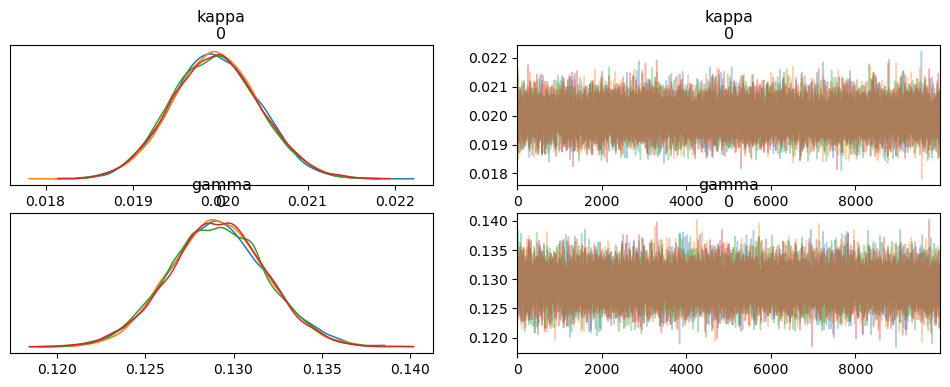

In [54]:
# This is a simple model. This is not good for our case. It will just get one k and one b for each session, but it won't incorporate everyone's data. Returns wonky values as far as I remember.

with pm.Model() as model_simple:

    kappa = pm.Beta('kappa',mu=0.3,sigma=0.2,shape=1)#np.size(SSA)) #mu=0.1, mu=0.07,sd=0.1 05
    gamma = pm.HalfNormal('gamma',sigma=0.5,shape=1)#np.size(SSA)) #mu=0.1, mu=0.005,sd=0.01 mu=0,
    
    prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(-gamma * ( data['cdd_delay_amt'].values/(1+(kappa*data['cdd_delay_wait'].values)) - 
                                                                   data['cdd_immed_amt'].values/(1+(kappa*data['cdd_immed_wait'].values)) ))))

    y_1 = pm.Bernoulli('y_1',p=prob,observed=data['cdd_trial_resp.corr'])

    trace_simple = pm.sample(10000, tune=10000, cores=4,target_accept=0.99)


# Call the trace whatever you like. This just saves it. You don't want to run a whole model and then accidentally x-out your window or refresh or something and lose it all!
az.plot_trace(trace_simple, var_names=["kappa","gamma"],compact=False)
# This is how you get a nice array. Note that this returns a pandas DataFrame, not a numpy array. Indexing is totally different.
Summary= az.summary(trace_simple,round_to=10)
# Again, call it what you want (yeah - call it what you want tooooo)
Summary.to_csv("Completely_pooled_model.csv")

In [60]:
boo = az.InferenceData.to_dataframe(trace_simple)
print(boo)
# pm.save_trace(trace_simple,'complete_pool.trace')

print(trace_simple)

AttributeError: module 'pymc' has no attribute 'save_trace'

1. Simple Non-Hierarchical Model

2. Simple Hierarchical Model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_k, sd_k, k, b]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 1506 seconds.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


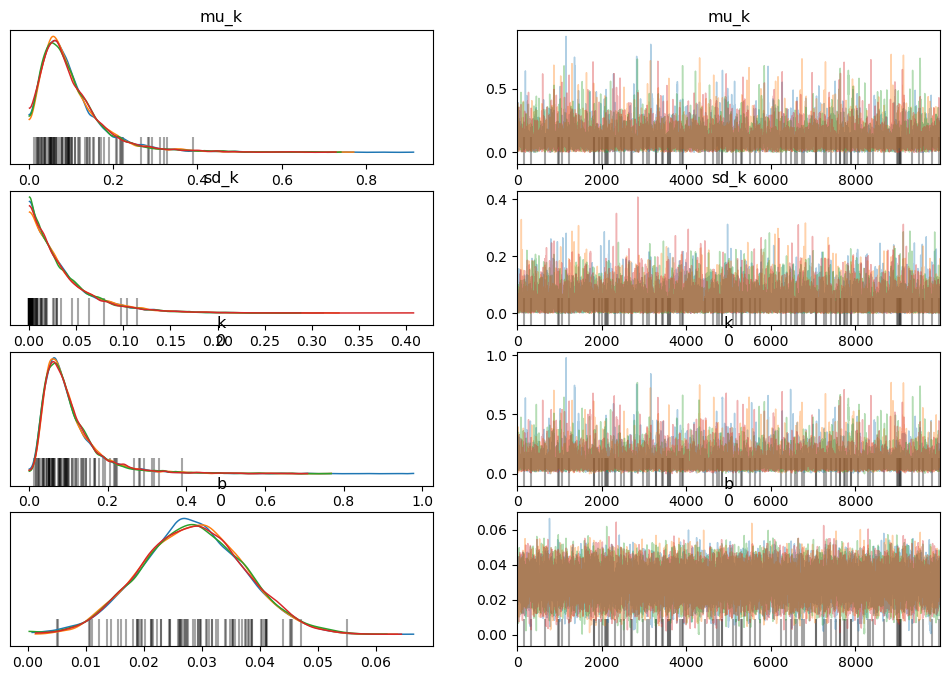

In [16]:
# This is a simple higherarchical model.

with pm.Model() as model_fancy:

    # Hyperparameters for k
    mu_k = pm.Beta('mu_k',mu=0.01,sigma=0.05)
    sd_k = pm.Beta('sd_k',mu=0.05,sigma=0.05)

    k = pm.Beta('k',mu=mu_k,sigma=sd_k,shape=1)#np.size(SSA)) #mu=0.1, mu=0.07,sd=0.1 05
    b = pm.HalfNormal('b',sigma=0.01,shape=1)#np.size(SSA)) #mu=0.1, mu=0.005,sd=0.01 mu=0,
    
    prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(-b * ( LLA/(1+(k*LLD)) - SSA/(1+(k*SSD)) ))))

    y_1 = pm.Bernoulli('y_1',p=prob,observed=y_simple)

    trace_fancy = pm.sample(10000, tune=10000, target_accept=0.999)


# Call the trace whatever you like. This just saves it. You don't want to run a whole model and then accidentally x-out your window or refresh or something and lose it all!
az.plot_trace(trace_fancy, var_names=["mu_k","sd_k","k","b"],compact=False)
# This is how you get a nice array. Note that this returns a pandas DataFrame, not a numpy array. Indexing is totally different.
Summary= az.summary(trace_fancy,round_to=10)
# Again, call it what you want (yeah - call it what you want tooooo)
Summary.to_csv("Summary_from_fancy_trace.csv")